# Map the Kanshin 2015 yeast data into a Cytoscape node annotation file - September 29, 2016


## Create a copy of the yeast data
Only copy the data files if they are needed.  This project is still a work in progress so we want to copy a fixed version of the input data so that the visualization does not change if there are updates in Dylan's repository.  Print the git log to get the commit id for the version of the data that was used.

Could also obtain the significance files and use them to create different colors for significant and insignificant peptides, as in the TPS EGFR study.

In [1]:
%%bash
cd C:/Users/agitter/Desktop/bmiToSave/outreach/IBS-SRP2016/dylan/osmotic-stress
git status
git log -1

On branch master
Your branch is up-to-date with 'origin/master'.
nothing to commit, working tree clean
commit f0de8aaa06e0f0493eff43ae3a9e9e63a8a22c5f
Author: Dylan Cronin <dcronin@bgsu.edu>
Date:   Mon Sep 26 21:29:50 2016 -0400

    Added README to define purposes of scripts


In [2]:
%pylab inline
import os, shutil, collections
import itertools as it

data_dir = os.path.join('..','data','Kanshin2015')
peptide_map_file = os.path.join(data_dir, 'peptide_map.txt')
time_series_file = os.path.join(data_dir, 'peptide_time_series.txt')

out_dir = os.path.join('..', 'cytoscape', 'yeast_time_series_092916')
network_file = os.path.join(out_dir, 'TPS_network.cys')
out_file = os.path.join(out_dir, 'cytoscape_time_series.txt')

# Dylan's git repository is the source of the Kanshin 2015 data
data_source_dir = r'C:\Users\agitter\Desktop\bmiToSave\outreach\IBS-SRP2016\dylan\osmotic-stress\Notebooks\Apply Thresholds'
peptide_map_source_file = os.path.join(data_source_dir, 'peptideMap.tsv')
time_series_source_file = os.path.join(data_source_dir, 'timeSeries.tsv')

network_source_dir = r'C:\Users\agitter\Desktop\bmiToSave\outreach\IBS-SRP2016\dylan\osmotic-stress\Results\network_visualization'
network_source_file = os.path.join(network_source_dir, 'TPS-correctName.cys')

if not os.path.exists(data_dir):
    print 'Creating {}'.format(data_dir)
    os.makedirs(data_dir)

if not os.path.exists(peptide_map_file):
    print 'Copying {}\nto\n{}\n'.format(peptide_map_source_file, peptide_map_file)
    shutil.copy2(peptide_map_source_file, peptide_map_file)

if not os.path.exists(time_series_file):
    print 'Copying {}\nto\n{}\n'.format(time_series_source_file, time_series_file)
    shutil.copy2(time_series_source_file, time_series_file)

if not os.path.exists(out_dir):
    print 'Creating {}'.format(out_dir)
    os.makedirs(out_dir)

if not os.path.exists(network_file):
    print 'Copying {}\nto\n{}\n'.format(network_source_file, network_file)
    shutil.copy2(network_source_file, network_file)

Populating the interactive namespace from numpy and matplotlib
Creating ..\data\Kanshin2015
Copying C:\Users\agitter\Desktop\bmiToSave\outreach\IBS-SRP2016\dylan\osmotic-stress\Notebooks\Apply Thresholds\peptideMap.tsv
to
..\data\Kanshin2015\peptide_map.txt

Copying C:\Users\agitter\Desktop\bmiToSave\outreach\IBS-SRP2016\dylan\osmotic-stress\Notebooks\Apply Thresholds\timeSeries.tsv
to
..\data\Kanshin2015\peptide_time_series.txt

Creating ..\cytoscape\yeast_time_series_092916
Copying C:\Users\agitter\Desktop\bmiToSave\outreach\IBS-SRP2016\dylan\osmotic-stress\Results\network_visualization\TPS-correctName.cys
to
..\cytoscape\yeast_time_series_092916\TPS_network.cys



## Load the peptide mapping
Each yeast ORF id maps to a set of peptides.  Plot the number of peptides per ORF.  Some ORFs have 27 peptides, which may be a good reason to filter and only include those that are signficant.  That would be hard to load into Cytoscape.

1596 unique yeast ORFs
Range of peptides per ORF: 1-27


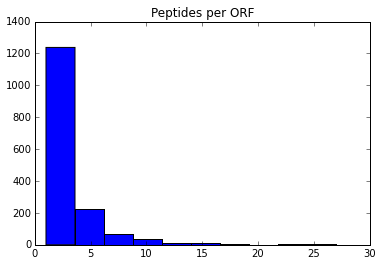

In [3]:
orf_to_peptide_map = collections.defaultdict(set)
peptide_to_orf_map = dict()
with open(peptide_map_file) as p_file:
    for line in p_file:
        parts = line.strip().split('\t')
        assert len(parts) == 2, 'Expected peptide and ORF'
        orf_to_peptide_map[parts[1]].add(parts[0])
        peptide_to_orf_map[parts[0]] = parts[1]

print '{} unique yeast ORFs'.format(len(orf_to_peptide_map))

peptides_per_orf = [len(peptides) for peptides in orf_to_peptide_map.values()]
print 'Range of peptides per ORF: {}-{}'.format(min(peptides_per_orf), max(peptides_per_orf))

hist(peptides_per_orf);
title('Peptides per ORF');

## Load the peptide time series
Create a map from the ORF to a list of associated time series profiles.  Impute missing data.  If the first time point is missing, set it to 0.  If later time points are missing, set them to the previous observed time point.

In [4]:
# Helper function
# Replaces missing values
# Collapses the list to a string
def clean_ts(time_series):
    if time_series[0] == '':
        time_series[0] = '0'

    for i in range(1, len(time_series)):
        if time_series[i] == '':
            time_series[i] = time_series[i-1]

    return ', '.join(time_series)

orf_ts_map = collections.defaultdict(list)
with open(time_series_file) as t_file:
    header = t_file.readline().strip()
    assert header == 'ModifiedPeptideSeq\tT00\tT05\tT10\tT15\tT20\tT25\tT30\tT35\tT40\tT45\tT50\tT55\tT60', 'Unexpected header'
    for line in t_file:
        # Don't strip all whitespace or trailing missing data will be lost
        parts = line.strip('\n').split('\t')
        assert len(parts) == 14
        
        # Find the matching ORF, add this time series to its list
        peptide = parts[0]
        time_series = clean_ts(parts[1:])
        assert peptide in peptide_to_orf_map, 'Unexpected peptide: {}'.format(peptide)
        orf = peptide_to_orf_map[peptide]
        orf_ts_map[orf].append(time_series)

# Check missing data handling
missing_orfs = ['YLR131C', 'YIR003W', 'YOL130W']
for orf in missing_orfs:
    print orf
    print '\n'.join(map(str,orf_ts_map[orf]))
    print

YLR131C
0.0394191831334, -0.0553364248649, -0.318883616213, 0.00863030514344, 0.0224743465749, -0.312778025578, 0.00417776078911, 0.168385305415, 0.0994972011702, 0.146915848087, -0.00424777070733, 0.245373962618, 0.133826527299
0.0159256899903, 0.0728604019312, -0.0301624785016, 0.0361868028478, 0.0230423926659, 0.110496881917, -0.0423527981998, -0.00860967475186, 0.0554733358984, 0.00173019613888, 0.0760117385696, -0.0188195435063, 0.0120680233091
0.0684644509669, -0.0421448186025, 0.0697021666301, -0.105023185301, -0.0734539795147, -0.0660950514183, -0.0354313227977, -0.0243257962354, -0.027292643446, -0.022448966907, 0.118093889387, 0.0285691521968, 0.0735460609152
0.0199153677077, 0.0323830053117, 0.0576928671683, 0.0792927672729, -0.0517729561208, 0.032100843167, 0.0824300999459, 0.0585243118408, 0.0665370023958, 0.0367494764279, -0.0144849970915, 0.0275787274743, 0.20576784015
0.0109230271848, 0.0499095224431, 0.0473987888754, -0.0518925937356, 0.0567222423745, -0.132925908893, 

## Write the time series to a file
Write one column for each possible peptide even though most columns will be mostly empty

In [5]:
cols = max(peptides_per_orf)
header = ['ORF']
# Make a header that is Peptide<i>
header.extend(map(lambda x, y: x + str(y), it.repeat('Peptide',cols), range(1,cols+1)))

with open(out_file, 'w') as o_file:
    o_file.write('\t'.join(header))
    o_file.write('\n')
    for orf in sorted(orf_ts_map.keys()):
        # Each line is the ORF id followed by all comma-separated time series profiles, one per column
        out_line = [orf]
        out_line.extend(orf_ts_map[orf])
        o_file.write('\t'.join(out_line))
        o_file.write('\n')